### Look at behavioral correlates of belief state value, re-factor and run a bunch of analyses from 20240612_some_trial_durations.ipynb but on Belief State Values. 
Specifically, look at: 
- Belief state values as function of num trials after block switch
- Probability of correct as a function of belief state value
- Probability of choosing card with preferred feature as a function of belief state value
- Decision time as a function of belief state value
- Time to cross fixate as a function of belief state value

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns
from scipy import stats


### Load all the data

In [2]:
num_bins = 10

def get_sess_beh(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_relative_block_position(beh, num_bins)
    beh = behavioral_utils.get_beliefs_per_session(beh, session)
    med = beh.BeliefStateValue.median()
    beh["BeliefStateValueBin"] = beh.apply(lambda x: 0 if x.BeliefStateValue < med else 1, axis=1)
    beh["PreferredBelief"] = beh[[f"{feat}Prob" for feat in FEATURES]].idxmax(axis=1).apply(lambda x: x[:-4])
    beh["BeliefLabel"] = beh.apply(lambda x: f"High Value Pref {x.PreferredBelief}" if x.BeliefStateValueBin == 1 else "Low Value", axis=1)
    beh["session"] = session
    return beh

In [3]:
# Monkey S
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
res = pd.concat(sessions.apply(lambda x: get_sess_beh(x, beh_path), axis=1).values)
res["CombinedIdx"] = np.arange(len(res))

In [5]:
res

,index,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,...,ESCHERProb,POLKADOTProb,RIPPLEProb,SWIRLProb,BeliefStateValue,BeliefStateValueBin,PreferredBelief,BeliefLabel,session,CombinedIdx
0,0,49,2,0,NaN,2258,Incorrect,2.0,11,SQUARE,...,0.083333,0.083333,0.083333,0.083333,0.328915,0,CIRCLE,Low Value,20180709,0
1,1,50,2,1,NaN,1881,Incorrect,2.0,11,SQUARE,...,0.097528,0.040750,0.097528,0.097528,0.331893,0,SQUARE,Low Value,20180709,1
2,2,51,2,2,NaN,2206,Incorrect,3.0,11,SQUARE,...,0.110206,0.056439,0.110206,0.046048,0.334192,0,ESCHER,Low Value,20180709,2
3,3,52,2,3,NaN,2005,Correct,0.0,11,SQUARE,...,0.124313,0.072522,0.124313,0.026120,0.335530,0,SQUARE,Low Value,20180709,3
4,4,53,2,4,NaN,1834,Correct,0.0,11,SQUARE,...,0.090212,0.057577,0.090212,0.067819,0.338974,0,SQUARE,Low Value,20180709,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,853,876,26,13,NaN,2654,Correct,0.0,4,CYAN,...,0.042511,0.016779,0.023828,0.026757,0.509555,1,CYAN,High Value Pref CYAN,20180910,28008
854,854,877,26,14,NaN,2557,Correct,0.0,4,CYAN,...,0.026026,0.015112,0.043323,0.019344,0.526579,1,CYAN,High Value Pref CYAN,20180910,28009
855,855,878,26,15,NaN,2696,Correct,0.0,4,CYAN,...,0.018585,0.014065,0.025749,0.037857,0.533984,1,CYAN,High Value Pref CYAN,20180910,28010
856,856,879,26,16,NaN,2567,Correct,0.0,4,CYAN,...,0.037037,0.013607,0.018437,0.023442,0.540309,1,CYAN,High Value Pref CYAN,20180910,28011


### Belief state values as function of num trials after block switch
Maybe just look at 1st 20 trials

<Axes: xlabel='TrialAfterRuleChange', ylabel='BeliefStateValue'>

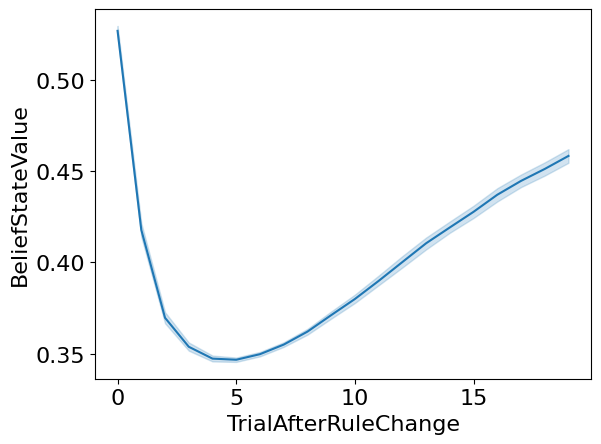

In [6]:
first_20 = res[res.TrialAfterRuleChange < 20]
fig, ax = plt.subplots()
sns.lineplot(first_20, x="TrialAfterRuleChange", y="BeliefStateValue", ax=ax)

### Probability of correct as a function of belief state value

In [7]:
out, bins = pd.cut(res["BeliefStateValue"], 10, labels=False, retbins=True)
res["BeliefStateValueBin"] = out
res["BeliefStateValueLabel"] = bins[out]


<Axes: xlabel='BeliefStateValueLabel', ylabel='ProbCorrect'>

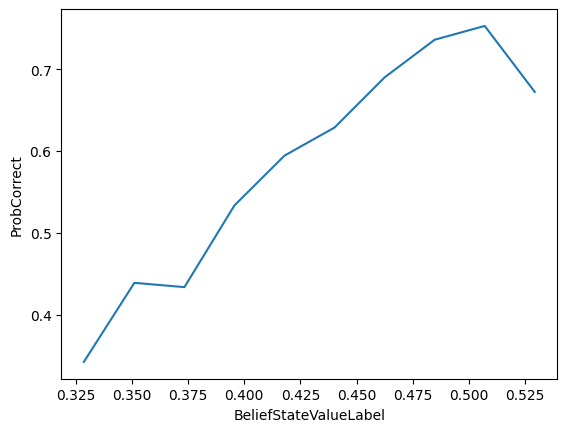

In [8]:
def calc_prob_correct(group):
    return len(group[group.Response == "Correct"]) / len(group)
prob_correct = res.groupby("BeliefStateValueBin", group_keys=False).apply(calc_prob_correct).reset_index(name='ProbCorrect')
prob_correct["BeliefStateValueLabel"] = bins[prob_correct["BeliefStateValueBin"].values]
fig, ax = plt.subplots()
sns.lineplot(prob_correct, x="BeliefStateValueLabel", y="ProbCorrect", ax=ax)


### Probability of preferred feat being chosen as a function of belief state value

<Axes: xlabel='BeliefStateValueLabel', ylabel='ProbPreferredChosen'>

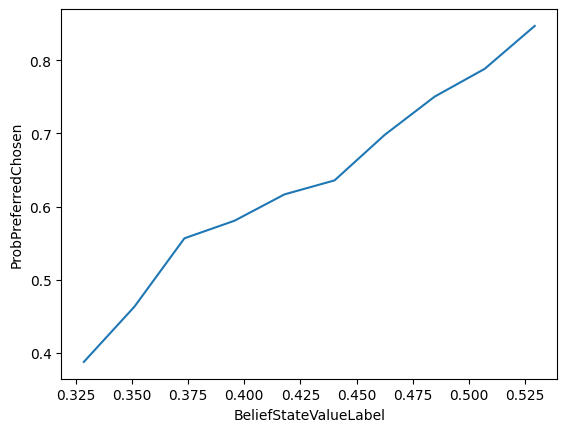

In [9]:
def calc_prob_preferred_chosen(group):
    group["PreferredBeliefChosen"] = group.apply(lambda x: x[FEATURE_TO_DIM[x.PreferredBelief]] == x.PreferredBelief, axis=1)
    return len(group[group.PreferredBeliefChosen]) / len(group)
prob_preferred_chosen = res.groupby("BeliefStateValueBin", group_keys=False).apply(calc_prob_preferred_chosen).reset_index(name='ProbPreferredChosen')
prob_preferred_chosen["BeliefStateValueLabel"] = bins[prob_preferred_chosen["BeliefStateValueBin"].values]
sns.lineplot(prob_preferred_chosen, x="BeliefStateValueLabel", y="ProbPreferredChosen")

### Decision time as a function of belief state value

In [4]:
res["DecisionTime"] = res.FeedbackOnset - 800 - res.StimOnset

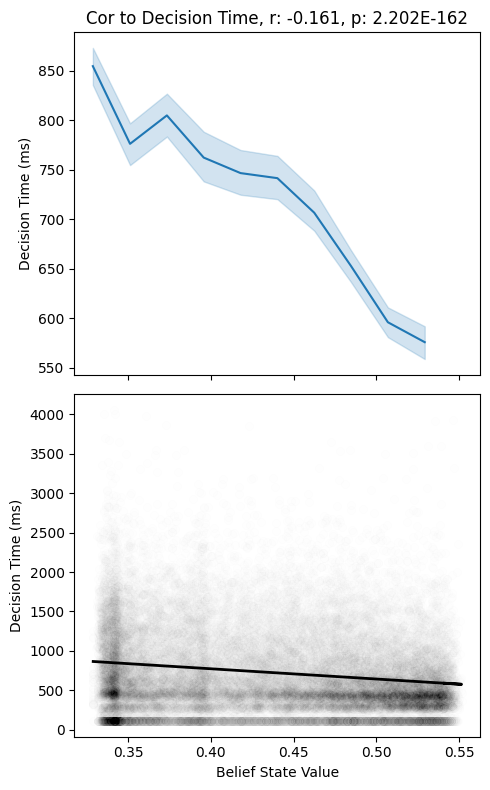

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
ax = axs[0]
sns.lineplot(res, x="BeliefStateValueLabel", y="DecisionTime", ax=ax)
ax.set_ylabel("Decision Time (ms)")

ax = axs[1]
slope, intercept, r_value, p_value, std_err = stats.linregress(res["BeliefStateValue"], res["DecisionTime"])
ax.scatter(res["BeliefStateValue"], res["DecisionTime"], alpha=0.005, color="black")
ax.plot(res["BeliefStateValue"], res["BeliefStateValue"] * slope + intercept, color="black", linewidth=2)
axs[0].set_title(f"Cor to Decision Time, r: {r_value:.3f}, p: {p_value:.3E}")
ax.set_xlabel("Belief State Value")
ax.set_ylabel("Decision Time (ms)")
fig.tight_layout()


### Cross fixation time as a function of belief state value

In [11]:
res["Time to Cross Fixate (ms)"] = res.FixationOnCross - res.FixCrossOn

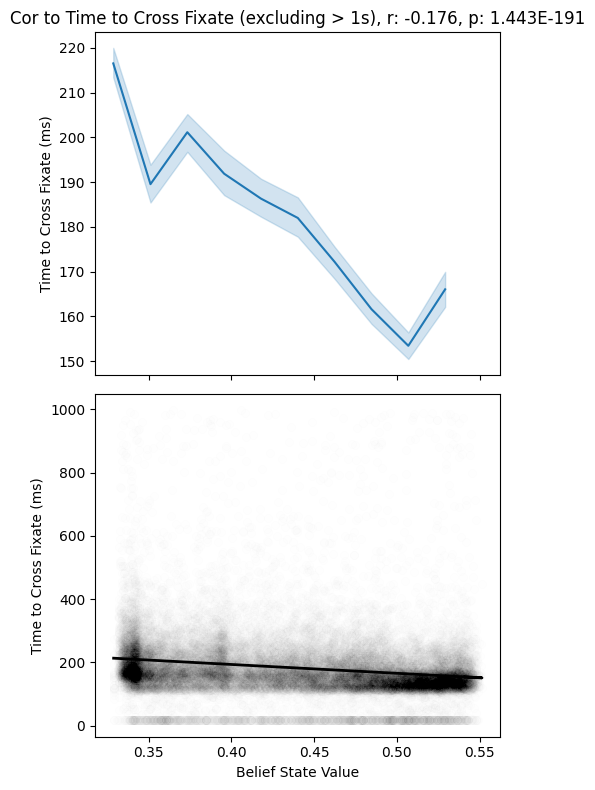

In [12]:
res_sub = res[res["Time to Cross Fixate (ms)"] < 1000]


# fig, ax = plt.subplots()
# sns.lineplot(res_sub, x="BeliefStateValueLabel", y="Time to Cross Fixate (ms)", ax=ax)
# ax.set_xlabel("Belief State Value")
# ax.set_ylabel("Time to cross fixate (ms)")


fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
ax = axs[0]
sns.lineplot(res_sub, x="BeliefStateValueLabel", y="Time to Cross Fixate (ms)", ax=ax)
ax.set_ylabel("Time to Cross Fixate (ms)")

ax = axs[1]
slope, intercept, r_value, p_value, std_err = stats.linregress(res_sub["BeliefStateValue"], res_sub["Time to Cross Fixate (ms)"])
ax.scatter(res_sub["BeliefStateValue"], res_sub["Time to Cross Fixate (ms)"], alpha=0.005, color="black")
ax.plot(res_sub["BeliefStateValue"], res_sub["BeliefStateValue"] * slope + intercept, color="black", linewidth=2)
axs[0].set_title(f"Cor to Time to Cross Fixate (excluding > 1s), r: {r_value:.3f}, p: {p_value:.3E}")
ax.set_xlabel("Belief State Value")
ax.set_ylabel("Time to Cross Fixate (ms)")
fig.tight_layout()

### Cross fixation time as a function of belief state value (excluding fixations longer than 5s)

Text(0, 0.5, 'Time to cross fixate (ms)')

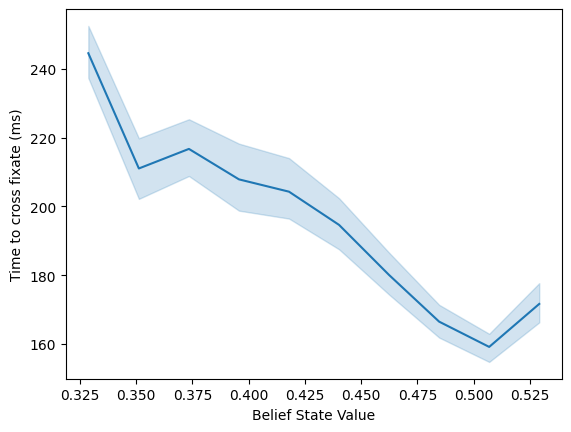

In [13]:
fig, ax = plt.subplots()
res_sub = res[res["Time to Cross Fixate (ms)"] < 5000]
sns.lineplot(res_sub, x="BeliefStateValueLabel", y="Time to Cross Fixate (ms)", ax=ax)
ax.set_xlabel("Belief State Value")
ax.set_ylabel("Time to cross fixate (ms)")

### Generate a joint figure for 2025 Cosyne Abstract

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


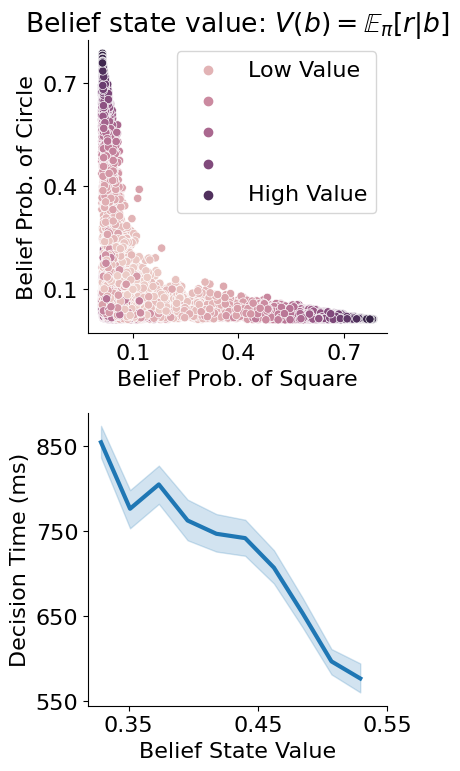

In [18]:
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2, 1, figsize=(4.5, 8))

ax = axs[0]
feat1 = "SQUARE"
feat2 = "CIRCLE"
res["Belief State Value"] = res.BeliefStateValue
sub_res = res[res.BeliefLabel.isin(["Low Value", f"High Value Pref {feat1}", f"High Value Pref {feat2}"])]
cmap = sns.cubehelix_palette(as_cmap=True)
sns.scatterplot(sub_res, x=f"{feat1}Prob", y=f"{feat2}Prob", hue="Belief State Value", cmap=cmap, ax=ax)
ax.set_xticks([.1, .4, .7,])
ax.set_xticklabels([.1, .4, .7,])
ax.set_yticks([.1, .4, .7,])
ax.set_yticklabels([.1, .4, .7,])
ax.set_xlabel("Belief Prob. of Square")
ax.set_ylabel("Belief Prob. of Circle")
ax.spines[['right', 'top']].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["Low Value", "", "", "", "High Value"])
ax.set_title(r"Belief state value: $ V(b) = \mathbb{E}_{\pi}[r|b]$")


ax = axs[1]
sns.lineplot(res, x="BeliefStateValueLabel", y="DecisionTime", linewidth=3, ax=ax)
ax.set_yticks([550, 650, 750, 850])
ax.set_yticklabels([550, 650, 750, 850])
ax.set_xticks([.35, .45, .55])
ax.set_xticklabels([.35, .45, .55])

ax.set_xlabel("Belief State Value")
ax.set_ylabel("Decision Time (ms)")
ax.spines[['right', 'top']].set_visible(False)

fig.tight_layout()
# fig.savefig("/data/patrick_res/figures/2025_cosyne_abstract/belief_state_value_beh.svg")


In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

tab_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
              'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 
              'tab:olive', 'tab:cyan']

for color in tab_colors:
    hex = mcolors.to_hex(color)
    print(f"{color}: {hex}")

tab:blue: #1f77b4
tab:orange: #ff7f0e
tab:green: #2ca02c
tab:red: #d62728
tab:purple: #9467bd
tab:brown: #8c564b
tab:pink: #e377c2
tab:gray: #7f7f7f
tab:olive: #bcbd22
tab:cyan: #17becf


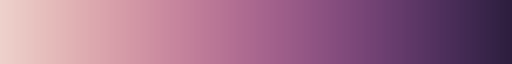

In [16]:
cmap = sns.cubehelix_palette(as_cmap=True)

In [12]:
fig

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8559578605899612, 0.6418993116910497, 0.6754191211563135],
 [0.739734329496642, 0.4765280683170713, 0.5959617419736206],
 [0.57916573903086, 0.33934576125314425, 0.5219003947563425],
 [0.37894937987024996, 0.2224702044652721, 0.41140014301575434],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]